策略原理：对于股票数据的走势有一种假设，走势可以分解为：长期趋势+中短期周期性波动+噪声数据。在去除长期趋势和噪声的情况下，可以利用Hilbert变换对中短期的周期性波动进行分析，该策略尝试将这种假设应用于加密货币交易，相比于股票市场，该策略更适合日内交易和高频交易。  
策略步骤：  
（1）消除噪声——MA  
（2）去除长期趋势影响——差分  
（3）计算Hilbert变换  
（4）根据变换结果的虚部做出择时判断：  
    虚部>0：看多  
    虚部<0：看空  

策略特点：绩效随着希尔伯特变换的两个周期有较大波动，因此在跨周期、回测数据起止日期不同以及币种改为EOS时都应当重新进行参数优化  

趋势判断：双EMA均线（短线21，长线53，经验值）  
中短期波动判断：收盘价的Hilbert变换（计算ma的周期maPeriod，希尔伯特变换的周期hilbertPeriod，是需要优化的参数）  
仓位管理：固定损失加仓法（可优化参数：StopRatio,takeLossRatio）  
风险管理：固定比例止盈止损（可优化参数：fixsize，Ratio） 
最长持有时间：20hours

In [10]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np
from scipy.signal import hilbert
from datetime import timedelta


########################################################################
# 策略继承CtaTemplate
class HilbertTransformStrategy(CtaTemplate):
    """基于希尔伯特变化的策略Demo"""
    className = 'HilbertTransformStrategy'
    author = 'Boyang Lyu'
    
    # 策略参数
    lot = 20        # 设置手数
    holdHour = 20    # 最长持有时间
    fastPeriod = 21
    slowPeriod = 53
    stopRatio = 0.03
    takeLossRatio = 15
    maPeriod = 27  #27
    hilbertPeriod = 30  #30
    fixsize = 20
    Ratio = 0.02
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    emaTrend = {}
    openTime = {}
    nPos = 0

    
    # 参数列表
    paramList = ['lot',
                 'holdHour',
                 'fastPeriod',
                 'slowPeriod',
                 'stopRatio',
                 'takeLossRatio',
                  'maPeriod',
                 'hilbertPeriod',
                 'fixsize',
                 'Ratio']    
    
    # 变量列表
    varList = ['transactionPrice',
               'emaTrend',
               'openTime',
               'nPos']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把ReversalStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.emaTrend = {s:0 for s in self.symbolList}
        self.openTime = {s: None for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        symbol = bar.vtSymbol
        self.onBarStopLoss(bar)
        lastOrder=self.transactionPrice[symbol]
    # 固定损失加仓模块______________________________________
        if (self.posDict[symbol+'_LONG'] != 0 and self.nPos < 3):    # 持有多头仓位并且加仓次数不超过3次
            if self.nPos >= 1:   # 上一次的加仓之后亏损达到原来盈利比例的一半
                if lastOrder / bar.close-1 >= self.Ratio / 2: 
                    self.sell(symbol,bar.close * 0.98, self.posDict[symbol+'_LONG']) # 全部头寸出场
            if bar.close / lastOrder-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.buy(symbol,bar.close * 1.02, self.fixsize)  # 加仓数量固定fixsize
                
        elif (self.posDict[symbol + "_SHORT"] != 0 and self.nPos < 3):    # 持有空头仓位并且加仓次数不超过3次
            if self.nPos >= 1:   # 上一次的加仓之后亏损达到原来盈利比例的一半
                if bar.close / lastOrder-1 >= self.Ratio / 2:
                    self.cover(symbol,bar.close * 1.02, self.posDict[symbol+'_SHORT']) # 全部头寸出场
            if lastOrder / bar.close-1 >= self.Ratio:   # 计算盈利比例,达到2%
                self.nPos += 1  # 加仓次数减少 1 次
                self.short(symbol,bar.close * 0.98, self.fixsize)  # 加仓数量固定fixsize
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol] * (1 - self.stopRatio)
        longProfit = self.transactionPrice[symbol] * (1 + self.takeLossRatio * self.stopRatio)
        shortStop = self.transactionPrice[symbol] * (1 + self.stopRatio)
        shortProfit = self.transactionPrice[symbol] * (1 - self.takeLossRatio * self.stopRatio)
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                self.cancelAll()
                self.sell(symbol,bar.close, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                self.cancelAll()
                self.cover(symbol,bar.close, self.posDict[symbol+'_SHORT'])

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am60.inited:
            return
        # 计算均线并判断趋势-------------------------------------------------
        fastEMa = ta.EMA(am60.close, self.fastPeriod)
        slowEMa = ta.EMA(am60.close, self.slowPeriod)
        
        if (fastEMa[-1] > slowEMa[-1]) and (fastEMa[-2] < slowEMa[-2]):
            self.emaTrend[symbol] = 1
        elif (fastEMa[-1] < slowEMa[-1]) and (fastEMa[-2] > slowEMa[-2]):
            self.emaTrend[symbol] = -1
        else:
            self.emaTrend[symbol] = self.emaTrend[symbol]

        # 计算持有时间
        if self.openTime[symbol]:
            if ((bar.datetime-self.openTime[symbol]) >= timedelta(hours=self.holdHour)):
                if self.posDict[symbol + "_LONG"] > 0:
                    self.sell(symbol, bar.close * 0.98, self.posDict[symbol + '_LONG'])
                    self.writeCtaLog('afterOpenOrder_Sell')
                    self.stopLossControl[symbol] = 1
                    self.openTime[symbol] = None
                elif self.posDict[symbol + "_SHORT"] > 0:
                    self.cover(symbol, bar.close * 1.015, self.posDict[symbol + "_SHORT"])
                    self.writeCtaLog('afterOpenOrder_Cover')
                    self.stopLossControl[symbol] = -1
                    self.openTime[symbol] = None
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def on30MinBar(self, bar):
        """收到30分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "30m") # 获取历史数组
        
        if not am60.inited:
            return
        # 计算希尔伯特变化需要的信号-------------------------------------------------
        ma = ta.MA(am60.close, self.maPeriod).reshape(-1)
        ma_diff = np.diff(ma).reshape(-1)
        ma_diff = ma_diff[~np.isnan(ma_diff)]
        hilbert_imag = np.imag(hilbert(ma_diff[-self.hilbertPeriod:-1])).reshape(-1)
        # 构建进出场逻辑-------------------------------------------------
        if (self.emaTrend[symbol] == 1) and (hilbert_imag[-1] > 0) and (self.posDict[symbol+'_LONG'] == 0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT'] == 0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.nPos = 0
                self.buy(symbol, bar.close*1.01, self.lot)
        
        elif (self.emaTrend[symbol] == -1) and (hilbert_imag[-1] < 0) and (self.posDict[symbol+'_SHORT']== 0):
            if self.posDict[symbol+'_LONG'] == 0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.nPos = 0
                self.short(symbol, bar.close*0.99, self.lot)
        # 发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [14]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180701 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181201 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(HilbertTransformStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-12-22 20:20:54.536141	开始回测
2018-12-22 20:20:54.536639	策略初始化
2018-12-22 20:20:55.136080	数据载入完成, 时间段:[20180623 04:00,20180701 12:00);数据量:11295
2018-12-22 20:20:55.137079	初始化预加载数据成功, 数据长度:11295
2018-12-22 20:20:55.137079	策略初始化完成
2018-12-22 20:20:55.137578	策略启动完成
2018-12-22 20:20:55.137578	回测时间范围:[20180701 12:00,20181201 12:00)
2018-12-22 20:20:55.137578	当前回放的时间段:[20180701 12:00,20181201 12:00)
2018-12-22 20:21:05.688836	数据载入完成, 时间段:[20180701 12:00,20181201 12:00);数据量:219233
2018-12-22 20:21:05.866504	数据载入完成, 时间段:[20180630 20:51,20180703 12:01);数据量:3790
2018-12-22 20:21:08.226196	数据载入完成, 时间段:[20180524 15:00,20180630 20:50);数据量:47285
2018-12-22 20:21:08.232683	WARNING: 该时间段:[20180703 12:01,20180703 13:00) 数据量为0!
2018-12-22 20:21:15.921686	Warning:当前平仓数量大于可平量，实盘下可能拒单, 请小心处理。
2018-12-22 20:21:15.922184	direction:卖平;volume:60;eveningDict={'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 20}
2018-12-22 20:21:16.7311

2018-12-22 20:21:39.518534	计算按日统计结果
2018-12-22 20:21:39.553988	------------------------------
2018-12-22 20:21:39.553988	首个交易日：	2018-07-01 00:00:00
2018-12-22 20:21:39.554470	最后交易日：	2018-12-01 00:00:00
2018-12-22 20:21:39.554470	总交易日：	154
2018-12-22 20:21:39.554470	盈利交易日	66
2018-12-22 20:21:39.554470	亏损交易日：	83
2018-12-22 20:21:39.554470	起始资金：	1000000
2018-12-22 20:21:39.554470	结束资金：	1,000,306.32
2018-12-22 20:21:39.554470	总收益率：	0.03%
2018-12-22 20:21:39.554470	年化收益：	0.05%
2018-12-22 20:21:39.554470	总盈亏：	306.32
2018-12-22 20:21:39.554470	最大回撤: 	-97.57
2018-12-22 20:21:39.554470	百分比最大回撤: -0.01%
2018-12-22 20:21:39.554470	总手续费：	21.31
2018-12-22 20:21:39.554970	总滑点：	15.56
2018-12-22 20:21:39.554970	总成交金额：	42,622.0
2018-12-22 20:21:39.554970	总成交笔数：	327
2018-12-22 20:21:39.554970	日均盈亏：	1.99
2018-12-22 20:21:39.554970	日均手续费：	0.14
2018-12-22 20:21:39.554970	日均滑点：	0.1
2018-12-22 20:21:39.554970	日均成交金额：	276.77
2018-12-22 20:21:39.554970	日均成交笔数：	2.12
2018-12-22 20:21:39.554970	日均收益率：	0.0%
2018-12

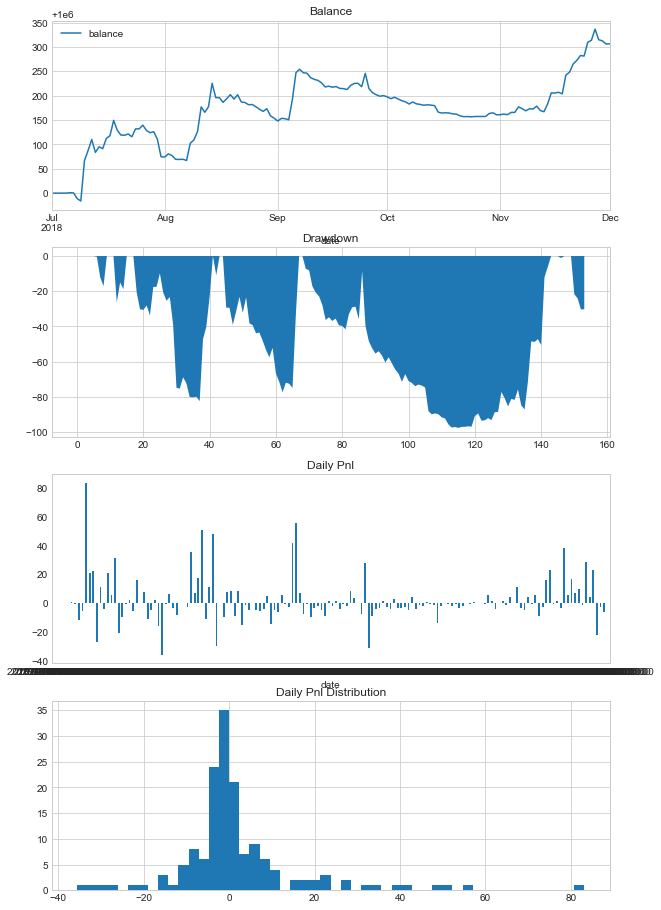

In [15]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-22 20:22:10.518969	计算回测结果
2018-12-22 20:22:10.544423	------------------------------
2018-12-22 20:22:10.544921	第一笔交易：	2018-07-06 16:09:00
2018-12-22 20:22:10.544921	最后一笔交易：	2018-12-01 11:58:00
2018-12-22 20:22:10.544921	总交易次数：	195
2018-12-22 20:22:10.544921	总盈亏：	306.25
2018-12-22 20:22:10.544921	最大回撤: 	-85.09
2018-12-22 20:22:10.544921	平均每笔盈利：	1.57
2018-12-22 20:22:10.544921	平均每笔滑点：	0.08
2018-12-22 20:22:10.544921	平均每笔佣金：	0.11
2018-12-22 20:22:10.544921	胜率		32.82%
2018-12-22 20:22:10.545421	盈利交易平均值	8.75
2018-12-22 20:22:10.545421	亏损交易平均值	-1.94
2018-12-22 20:22:10.545421	盈亏比：	4.52


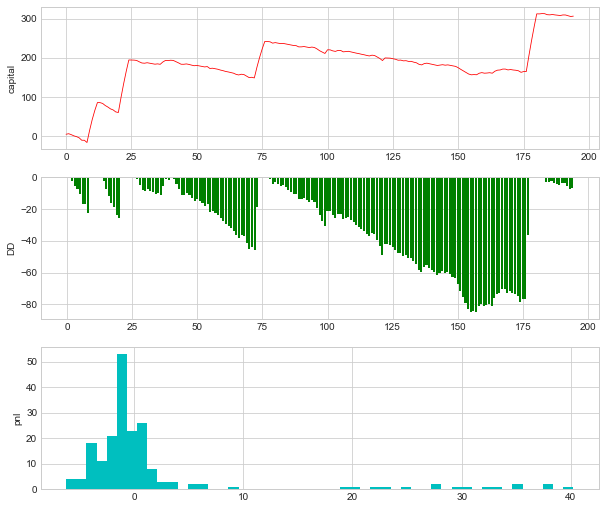

In [16]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [6]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('tradeDatetime')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
tradeDatetime,,,,,,,,,,,,,,,,,,
2018-07-07 12:00:00,多,,,0.0,,开仓,1,,6599.45,None,,,1,20180707 12:00:00,20,1,BTCUSDT:binance,1
2018-07-08 01:00:00,空,,,0.0,,平仓,2,,6562.26,None,,,2,20180708 01:00:00,20,2,BTCUSDT:binance,2
2018-07-08 01:00:00,空,,,0.0,,开仓,3,,6562.26,None,,,3,20180708 01:00:00,20,3,BTCUSDT:binance,3
2018-07-08 07:27:00,多,,,0.0,,平仓,4,,6795.01,None,,,4,20180708 07:27:00,20,4,BTCUSDT:binance,4
2018-07-08 08:00:00,多,,,0.0,,开仓,5,,6753.48,None,,,5,20180708 08:00:00,20,5,BTCUSDT:binance,5
2018-07-10 14:00:00,空,,,0.0,,平仓,6,,6618.13,None,,,6,20180710 14:00:00,20,6,BTCUSDT:binance,6
2018-07-10 14:00:00,空,,,0.0,,开仓,7,,6618.13,None,,,7,20180710 14:00:00,20,7,BTCUSDT:binance,7
2018-07-10 17:40:00,空,,,0.0,,开仓,8,,6474.55,None,,,8,20180710 17:40:00,20,8,BTCUSDT:binance,8
2018-07-10 19:40:00,空,,,0.0,,开仓,9,,6340.24,None,,,9,20180710 19:40:00,20,9,BTCUSDT:binance,9


In [148]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting  import OptimizationSetting
# 优化配置
setting = OptimizationSetting()                # 新建一个优化任务设置对象
setting.setOptimizeTarget('sharpeRatio')       # 设置优化排序的目标是夏普

setting.addParameter('maPeriod', 20, 40, 4)
setting.addParameter('hilbertPeriod', 5, 29, 3)

setting.addParameter('symbolList', ['BTCUSDT:binance']) 

import time
start = time.time()
# 执行单线程优化
resultList = engine.runOptimization(HilbertTransformStrategy, setting)
# 执行多进程优化一般会改写成py文件然后用多线程运行，提高优化速度。
# resultList = engine.runParallelOptimization(Strategy, setting)
# print('耗时：%s' %(time.time()-start))

2018-12-19 12:06:31.608001	------------------------------
2018-12-19 12:06:31.608001	setting: {'maPeriod': 20, 'hilbertPeriod': 5, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A812A7B8C8>, <__main__.HilbertTransformStrategy object at 0x000001A8121CCC88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_3Min_bar函数functools.partial(<function HilbertTransformStrategy.on3MinBar at 0x000001A8009A37B8>, <__main__.HilbertTransformStrategy object at 0x000001A8121CCC88>)
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function HilbertTransformStrategy.onBar at 0x000001A812A7B378>, <__main__.HilbertTransformStrategy object at 0x000001A8121CCC88>)
2018-12-19 12:06:31.640942	开始回测
2018-12-19 12:06:31.640942	策略初始化
2018-12-19 12:06:31.642954	载入历史数据。数据范围:[20180524 04:00,20180601 12:00)
2018-12-19 12:06:32.093939	 当前品种 BTCUSDT:bina

2018-12-19 12:07:45.975422	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:07:45.979913	载入完成，数据量：12000
2018-12-19 12:07:45.980412	策略初始化完成
2018-12-19 12:07:45.980911	策略启动完成
2018-12-19 12:07:45.981410	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:07:46.009358	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:07:56.206526	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:07:56.272900	载入完成，数据量：261728
2018-12-19 12:07:56.273399	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:07:56.275395	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:07:56.471543	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:07:56.472541	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:07:56.496995	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:0

2018-12-19 12:09:10.887984	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:09:10.901960	载入完成，数据量：53630
2018-12-19 12:09:10.907947	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:09:10.915433	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:09:10.915433	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:10:45.122069	数据回放结束ss: 100%    
2018-12-19 12:10:45.123067	计算按日统计结果
2018-12-19 12:10:45.246837	------------------------------
2018-12-19 12:10:45.247337	setting: {'maPeriod': 20, 'hilbertPeriod': 26, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128B51E0>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:11:57.493662	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:11:57.497170	载入完成，数据量：12000
2018-12-19 12:11:57.497655	策略初始化完成
2018-12-19 12:11:57.497655	策略启动完成
2018-12-19 12:11:57.497655	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:11:57.520128	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:12:07.724698	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:12:07.790059	载入完成，数据量：261728
2018-12-19 12:12:07.791072	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:12:07.792555	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:12:07.971240	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:12:07.972238	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:12:07.990703	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:1

2018-12-19 12:13:21.483978	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:13:21.497451	载入完成，数据量：53630
2018-12-19 12:13:21.504440	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:13:21.511427	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:13:21.511926	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:14:54.967748	数据回放结束ss: 100%    
2018-12-19 12:14:54.968747	计算按日统计结果
2018-12-19 12:14:55.090018	------------------------------
2018-12-19 12:14:55.090018	setting: {'maPeriod': 24, 'hilbertPeriod': 20, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128AF2F0>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:16:07.941810	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:16:07.945320	载入完成，数据量：12000
2018-12-19 12:16:07.945801	策略初始化完成
2018-12-19 12:16:07.945801	策略启动完成
2018-12-19 12:16:07.945801	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:16:07.969758	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:16:17.997556	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:16:18.064930	载入完成，数据量：261728
2018-12-19 12:16:18.065431	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:16:18.067427	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:16:18.258360	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:16:18.259857	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:16:18.286806	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:1

2018-12-19 12:17:31.328788	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:17:31.341251	载入完成，数据量：53630
2018-12-19 12:17:31.347753	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:17:31.355226	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:17:31.355226	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:19:05.370670	数据回放结束ss: 100%    
2018-12-19 12:19:05.371169	计算按日统计结果
2018-12-19 12:19:05.487452	------------------------------
2018-12-19 12:19:05.487452	setting: {'maPeriod': 28, 'hilbertPeriod': 14, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128AA048>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:20:17.320260	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:20:17.324252	载入完成，数据量：12000
2018-12-19 12:20:17.325251	策略初始化完成
2018-12-19 12:20:17.325251	策略启动完成
2018-12-19 12:20:17.325749	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:20:17.347223	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:20:27.485502	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:20:27.550880	载入完成，数据量：261728
2018-12-19 12:20:27.551892	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:20:27.553377	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:20:27.736035	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:20:27.737033	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:20:27.755498	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:2

2018-12-19 12:21:41.751024	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:21:41.765501	载入完成，数据量：53630
2018-12-19 12:21:41.771985	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:21:41.778972	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:21:41.779472	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:23:15.852134	数据回放结束ss: 100%    
2018-12-19 12:23:15.852134	计算按日统计结果
2018-12-19 12:23:15.973905	------------------------------
2018-12-19 12:23:15.974404	setting: {'maPeriod': 32, 'hilbertPeriod': 8, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128B52F0>, <__main__.HilbertTransformStrategy object at 0x00000

2018-12-19 12:24:28.308781	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:24:28.312774	载入完成，数据量：12000
2018-12-19 12:24:28.313278	策略初始化完成
2018-12-19 12:24:28.313278	策略启动完成
2018-12-19 12:24:28.313278	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:24:28.336743	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:24:38.199689	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:24:38.265052	载入完成，数据量：261728
2018-12-19 12:24:38.265552	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:24:38.268581	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:24:38.457729	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:24:38.459725	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:24:38.489671	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:2

2018-12-19 12:25:52.163373	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:25:52.183337	载入完成，数据量：53630
2018-12-19 12:25:52.192819	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:25:52.201303	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:25:52.201303	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:27:28.222771	数据回放结束ss: 100%    
2018-12-19 12:27:28.223769	计算按日统计结果
2018-12-19 12:27:28.343546	------------------------------
2018-12-19 12:27:28.343546	setting: {'maPeriod': 32, 'hilbertPeriod': 29, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128B58C8>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:28:39.823118	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:28:39.826629	载入完成，数据量：12000
2018-12-19 12:28:39.827127	策略初始化完成
2018-12-19 12:28:39.827127	策略启动完成
2018-12-19 12:28:39.827127	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:28:39.849586	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:28:49.936798	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:28:50.012671	载入完成，数据量：261728
2018-12-19 12:28:50.013656	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:28:50.014654	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:28:50.196316	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:28:50.197813	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:28:50.220281	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:2

2018-12-19 12:30:03.341281	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:30:03.354757	载入完成，数据量：53630
2018-12-19 12:30:03.361244	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:30:03.368248	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:30:03.368749	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:31:37.106568	数据回放结束ss: 100%    
2018-12-19 12:31:37.107049	计算按日统计结果
2018-12-19 12:31:37.242798	------------------------------
2018-12-19 12:31:37.242798	setting: {'maPeriod': 36, 'hilbertPeriod': 23, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128B5378>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:32:49.298589	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:32:49.302580	载入完成，数据量：12000
2018-12-19 12:32:49.303579	策略初始化完成
2018-12-19 12:32:49.303579	策略启动完成
2018-12-19 12:32:49.304077	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:32:49.325038	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:32:59.337619	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:32:59.413963	载入完成，数据量：261728
2018-12-19 12:32:59.414962	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:32:59.416957	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:32:59.602128	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:32:59.603125	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:32:59.622573	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:3

2018-12-19 12:34:13.746833	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:34:13.760310	载入完成，数据量：53630
2018-12-19 12:34:13.767295	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:34:13.774798	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:34:13.774798	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[

[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7455.4799999999996, 'close': 7491.2200000000003, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 962.82870400000024, 'openInterest': 0}
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528090000 , 20180601120000]
[INFO] 品种BTCUSDT:binance的60mK线准备就绪,当前K线时间为20180601120000
2018-12-19 12:35:47.442518	数据回放结束ss: 100%    
2018-12-19 12:35:47.443016	计算按日统计结果
2018-12-19 12:35:47.563792	------------------------------
2018-12-19 12:35:47.564299	setting: {'maPeriod': 40, 'hilbertPeriod': 17, 'symbolList': ['BTCUSDT:binance']}
仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function HilbertTransformStrategy.on60MinBar at 0x000001A8128AF400>, <__main__.HilbertTransformStrategy object at 0x0000

2018-12-19 12:36:59.977462	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:36:59.981953	载入完成，数据量：12000
2018-12-19 12:36:59.982453	策略初始化完成
2018-12-19 12:36:59.982952	策略启动完成
2018-12-19 12:36:59.982952	开始回放回测数据,回测范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:37:00.011399	载入历史数据。数据范围:[20180601 12:00,20181201 12:00)
2018-12-19 12:37:10.710452	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:37:10.780322	载入完成，数据量：261728
2018-12-19 12:37:10.781320	当前回放数据:[20180601 12:00,20181201 12:00)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601120000
2018-12-19 12:37:10.782818	载入历史数据。数据范围:[20180531 20:51,20180603 12:01)
2018-12-19 12:37:10.961214	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:37:10.962212	载入完成，数据量：3790
[INFO] 品种BTCUSDT:binance的历史1mK线更新，范围为:[20180601102100 , 20180601120000]
[INFO] 品种BTCUSDT:binance的1mK线准备就绪,当前K线时间为20180601120000
[INFO] 品种BTCUSDT:binance开始生成未完成的60mK线数据,时间起点为:20180601120000
2018-12-19 12:37:10.985169	载入历史数据。数据范围:[20180424 15:00,20180531 20:50)
2018-12-19 12:3

2018-12-19 12:38:24.736011	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:38:24.751003	载入完成，数据量：53630
2018-12-19 12:38:24.756983	载入历史数据。数据范围:[20180603 12:01,20180603 13:00)
2018-12-19 12:38:24.764458	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-19 12:38:24.764458	！！ 数据量为 0 ！！
[INFO] 品种BTCUSDT:binance的历史60mK线更新，范围为:[20180528080000 , 20180601110000]
[INFO] 品种BTCUSDT:binance开始生成未完成的3mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance的历史3mK线更新，范围为:[20180601070000 , 20180601115700]
[INFO] 品种BTCUSDT:binance开始生成1mK线数据,时间起点为:20180601120100
[INFO] 品种BTCUSDT:binance开始生成60mK线数据,时间起点为:20180601120000
[INFO] 品种BTCUSDT:binance开始生成3mK线数据,时间起点为:20180601120000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'BTCUSDT:binance', 'symbol': 'BTCUSDT', 'exchange': 'binance', 'open': 7495.13, 'high': 7497.07, 'low': 7470.0, 'close': 7470.0900000000001, 'date': '20180601', 'time': '12:00:00.000000', 'datetime': datetime.datetime(2018, 6, 1, 12, 0), 'volume': 47.442653, 'openInterest': 0}
[